In [1]:
import sys
sys.path.insert(1, '../src')


import argparse
import logging
import os
from mypredictor import Predictor
from metric import Metric
import csv
import json
import pickle
from preprocess import Embedding, CSDataset
import torch
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
model_dir = "..\model\moreData_clean_noCorrect_256"
epoch = 3
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(filename)s[line:%(lineno)d] - %(levelname)s: %(message)s')

model_path = os.path.join(model_dir, "model.pkl.{}".format(epoch))
config_path = os.path.join(model_dir, "config.json")

logging.info('Loading configuration file from {}'.format(config_path))
with open(config_path) as f:
    config = json.load(f)

embedding_pkl_path = os.path.join(model_dir, config["embedding_pkl_path"])
val_pkl_path = os.path.join(model_dir, config["val_pkl_path"])
labelEncoder_path = os.path.join(model_dir, config["labelEncoder_path"])
with open(embedding_pkl_path, "rb") as f:
    config["model_parameters"]["embedding"] = pickle.load(f).vectors
    logging.info( "Load embedding from {}".format(embedding_pkl_path))
with open(val_pkl_path, "rb") as f:
    config["model_parameters"]["valid"] = pickle.load(f)
    logging.info( "Load val from {}".format(val_pkl_path))
with open(labelEncoder_path, "rb") as f:
    config["model_parameters"]["labelEncoder"] = pickle.load(f)
    logging.info( "Load labelEncoder from {}".format(labelEncoder_path))

le = config["model_parameters"]["labelEncoder"]
num_classes = len(le.classes_)
class_list = list(le.classes_)

print(class_list)

predictor = Predictor(metric=Metric(), **config["model_parameters"])
predictor.load(model_path)


logging.info("Loading testing data.")
#with open(args.test_data_path, "rb") as f:
#    pass
valid = config["model_parameters"]["valid"] # CSDataset
test = valid


logging.info("Predicting...")
predicts, solution = predictor.predict_dataset(test, test.collate_fn)


2019-07-25 09:35:26,284 - <ipython-input-2-258492a3a8c6>[line:8] - INFO: Loading configuration file from ..\model\moreData_clean_noCorrect_256\config.json
2019-07-25 09:35:50,282 - <ipython-input-2-258492a3a8c6>[line:17] - INFO: Load embedding from ..\model\moreData_clean_noCorrect_256\embedding.pkl
2019-07-25 09:35:50,362 - <ipython-input-2-258492a3a8c6>[line:20] - INFO: Load val from ..\model\moreData_clean_noCorrect_256\val.pkl
2019-07-25 09:35:50,369 - <ipython-input-2-258492a3a8c6>[line:23] - INFO: Load labelEncoder from ..\model\moreData_clean_noCorrect_256\labelEncoder.pkl


['Does the program support certain features?', 'Download/installation issues with Application Manager.', 'Error message pops up when I perform some action.', 'How do I …?', 'How to activate/register my product?', 'How to edit?', 'How to produce file?', 'How to set preferences/settings?', 'How to use certain effects/features?', 'I cannot install/download', 'I forget my password.', 'I have a suggestion', 'I have a suggestion.', 'I have activation problem.', 'I have activation/registration problem.', 'I have already paid, but …', 'I have component activation problem', 'I have install/uninstall/upgrade/patch problems.', 'I have other feedback', 'I have other install/uninstall problems.', 'I have other issue(s)', 'I have other membership question.', 'I have other product feature question.', 'I have other product info/feature question', 'I have other purchasing question.', 'I have other questions.', 'I have other questions/issues.', 'I have other trouble(s).', 'I have pricing/discount questi

2019-07-25 09:35:50,419 - mypredictor.py[line:32] - INFO: Embedding size: (1551018,300)
2019-07-25 09:35:54,610 - mypredictor.py[line:40] - INFO: Learning_rate: 0.01
2019-07-25 09:35:54,613 - mypredictor.py[line:43] - INFO: Loss: BCEWithLogitsLoss()
2019-07-25 09:35:54,697 - <ipython-input-2-258492a3a8c6>[line:35] - INFO: Loading testing data.
2019-07-25 09:35:54,698 - <ipython-input-2-258492a3a8c6>[line:42] - INFO: Predicting...
predicting:   0%|                              | 0/84 [00:00<?, ?it/s]

torch.Size([128, 100, 256]) torch.Size([1, 128, 256])


predicting: 100%|█████████████████████| 84/84 [00:15<00:00,  5.25it/s]


In [3]:
def analysis(predicts, gt, labels):
    matrix = confusion_matrix(gt, predicts, labels=labels)
    df = pd.DataFrame(matrix, columns=labels, index=labels)
    #print(df.head())
    
    plt.figure(figsize=(35, 15))
    plt.title('Confusion Matrix', y=1.03, fontsize = 25)
    #cmap = sn.cubehelix_palette(start = 1.5, rot = 3, gamma=0.8, as_cmap = True)
    heatmap = sn.heatmap(df, annot=True, annot_kws={"size": 16}) # , cmap=cmap
    plt.ylabel('Ground Truth', fontsize = 20)
    plt.xlabel('Prediction', fontsize = 20)
    heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, horizontalalignment="right")
    plt.savefig('ConfusionMatrix_newdata.jpg', bbox_inches = "tight")
    
    normalized_matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis] # normalize
    normalized_matrix = np.nan_to_num(normalized_matrix).round(2)
    df = pd.DataFrame(normalized_matrix, columns=labels, index=labels)
    
    plt.figure(figsize=(35, 15))
    plt.title('Normalized Confusion Matrix', y=1.03, fontsize = 25)
    #cmap = sn.cubehelix_palette(start = 1.5, rot = 3, gamma=0.8, as_cmap = True)
    heatmap = sn.heatmap(df, annot=True, annot_kws={"size": 16}) # , cmap=cmap
    plt.ylabel('Ground Truth', fontsize = 20)
    plt.xlabel('Prediction', fontsize = 20)
    heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, horizontalalignment="right")
    plt.savefig('Normalized_ConfusionMatrix_newdata.jpg', bbox_inches = "tight")


    n = 0
    n_correct = 0
    '''
    for i in range(len(gt)):
        n += 1
        if gt[i][maxindex[i]] == 1:
            n_correct += 1
    print("Accuracy: {}".format(n_correct / n))
    print(len(matrix), len(matrix[0]))
    '''

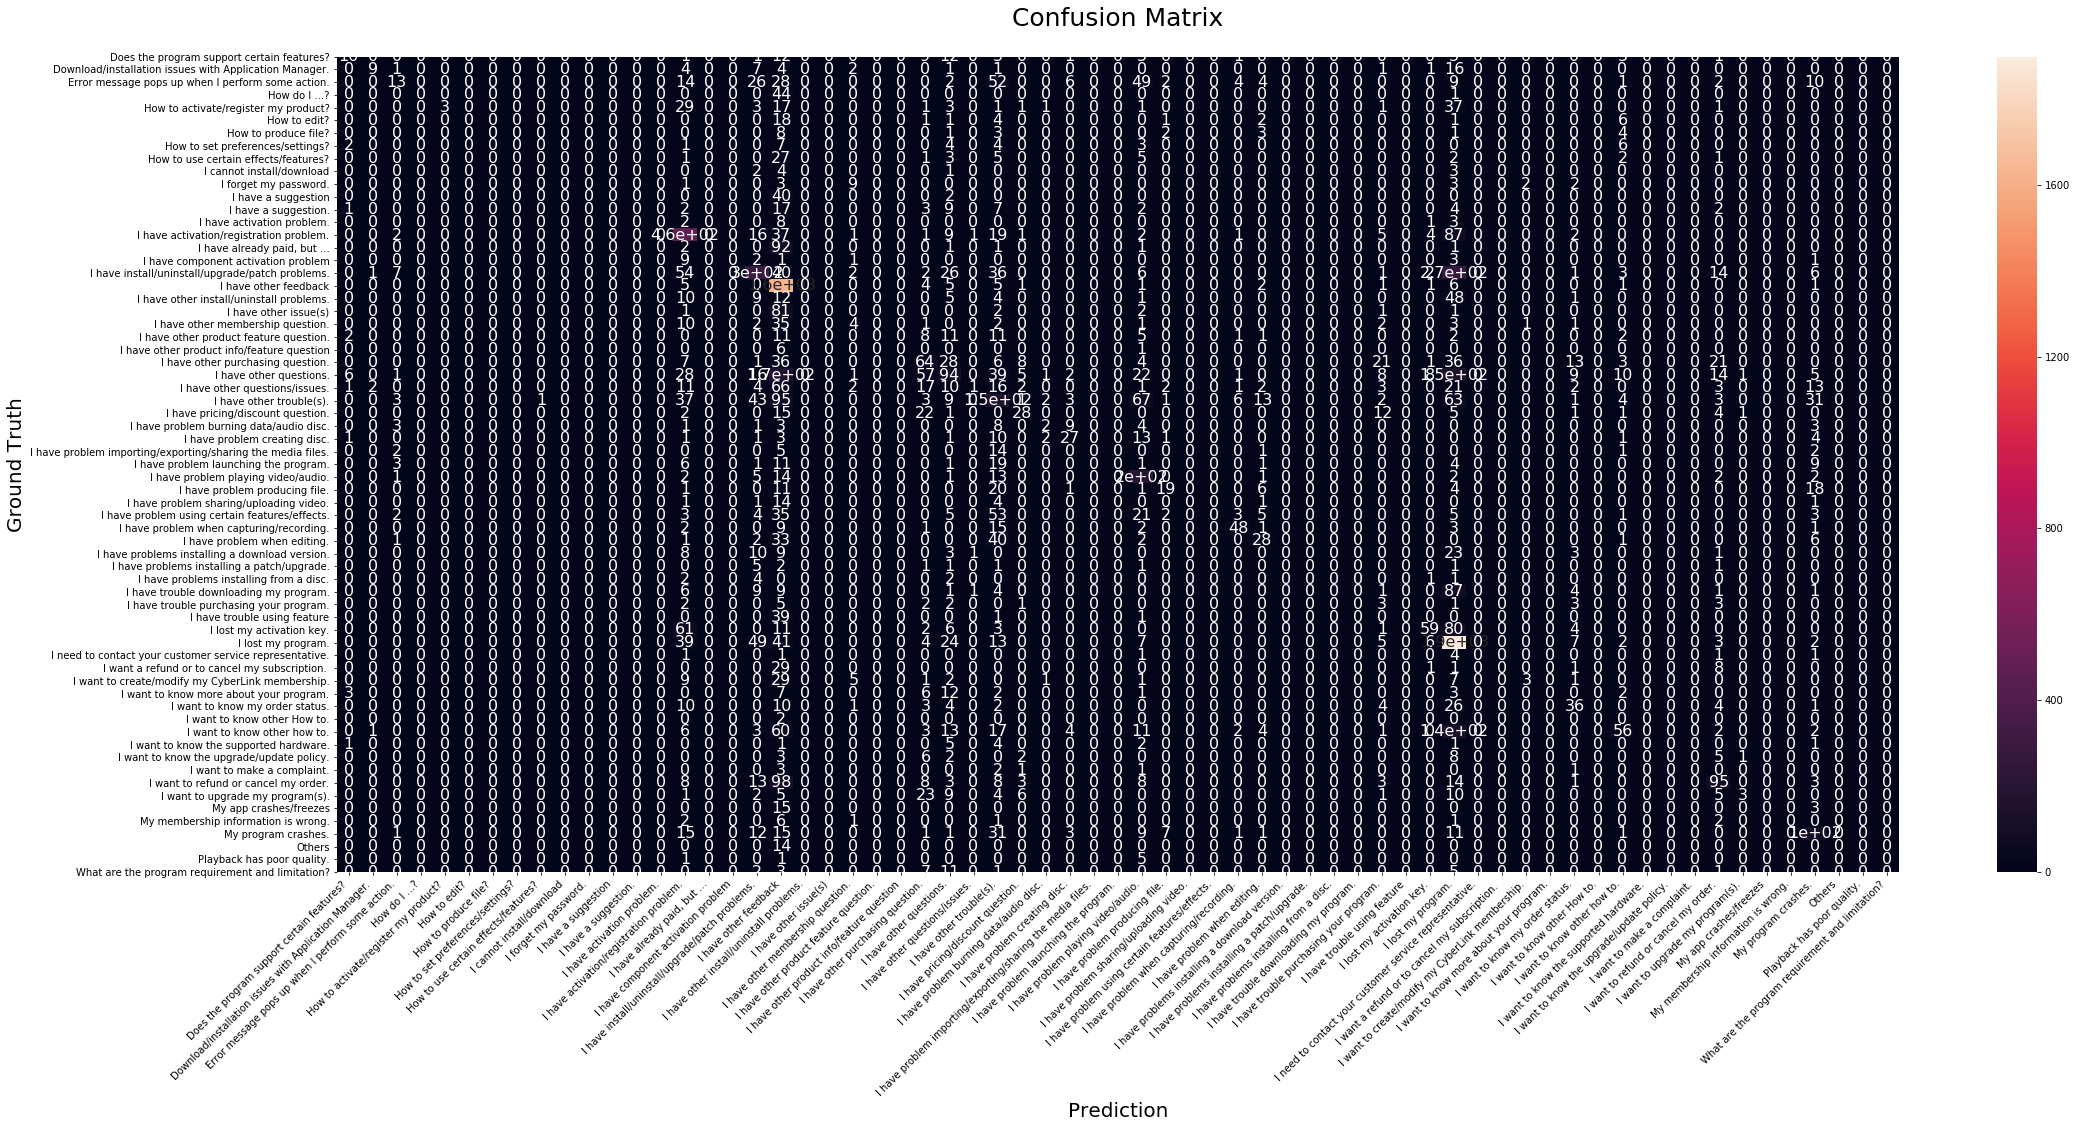

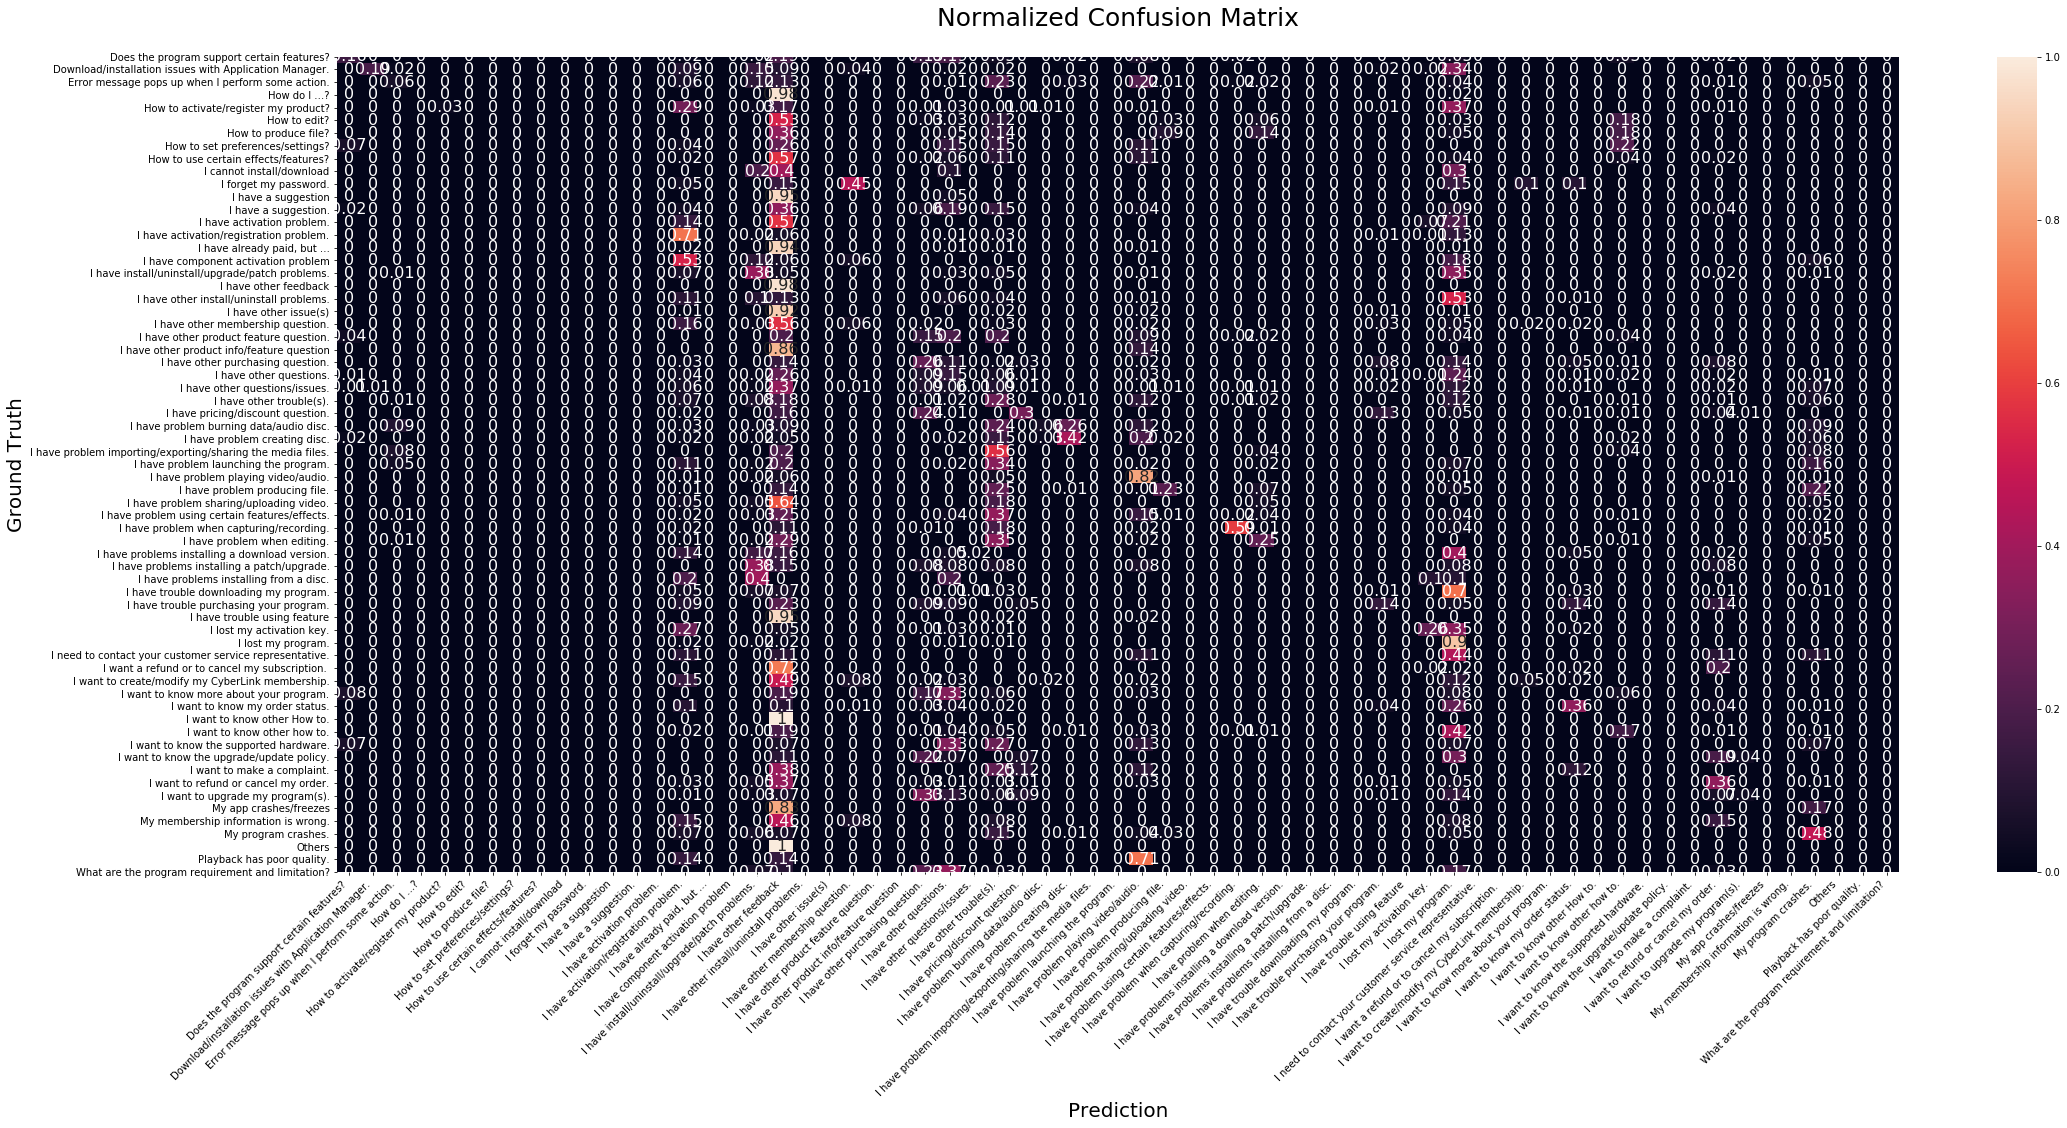

In [4]:
predicts_index = torch.argmax(predicts, dim=1)
gt_index = torch.argmax(solution, dim=1)
predicts_str = list(le.inverse_transform(predicts_index))
gt_str = list(le.inverse_transform(gt_index))
    
analysis(predicts_str, gt_str, labels=class_list)